<h1>Generating a Circuit for Hamiltonian Simulation Using QSP</h1>

<h2> Distribution Statement </h2>

DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

<br>
This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

<br>
© 2022 Massachusetts Institute of Technology.

<br>
<br>
The software/firmware is provided to you on an As-Is basis

<br>
<br>
Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

This notebook describes a method for generating a quantum circuit for Hamiltonian simulation using the Quantum Signal Processing (QSP) algorithm.

The user of this notebook should proovide the following values:

- Hamiltonian of the problem to simulate
- Requested precision of circuit
- Timestep where simulation occurs

__Note:__ This notebook will generate a single circuit which corresponds to a single timestep. If multiple timesteps are desired for simulation, and one desires to maintain a precision threshold, the number of phased-iterates will necessarily change over time, resulting in different circuits. 

For additional information on QSP and formulating a Hamiltonian for use with QSP, please see accompanying notebooks.

In [1]:
###
### Imports to support the pyQSP Gate-Based Hamiltonian simulation
###
import sys
import os
import cirq
from cirq.contrib.svg import SVGCircuit

import pyLIQTR.QSP.gen_qsp                 as qspFuncs
import pyLIQTR.QSP.QSP                     as pQSP
import pyLIQTR.sim_methods.quantum_ops  as qops        


from pyLIQTR.QSP.Hamiltonian             import Hamiltonian as pyH
from pyLIQTR.QSP.qsp_helpers             import qsp_decompose_once, print_to_openqasm, prettyprint_qsp_to_qasm
from pyLIQTR.gate_decomp.cirq_transforms import clifford_plus_t_direct_transform


Define the Hamiltonian, required precision, and time

In [2]:
###
### User Input: Transverse Ising Field
###
#Physical problem specification, this is equivalent to the XXZ Hamiltonian specified in Tutorials 1 & 2. 

#We note that increasing N will increase circuit size (both in terms of width and depth), since additional
#qubits are required to model the problem (width)
N    =   4;        J_z  =   1.0;          h_x  =  -1.0
tuples,types,coeffs = qops.params_heisenberg_1d(N,J_z=J_z,h_x=h_x,periodic=False)
ham_strings = qops.ps_text_full_set(tuples,types,N,Coeffs=coeffs)

# Algorithm specification
#Increasing the precision or increasing the sim time are likely to increase circuit depth, since additional QSP
#terms may be introduced
required_precision   = 1e-2
timestep_of_interest = 0.05 # sim_time


qsp_H = pyH(ham_strings)

print('\n: --- Visual Check Hamiltonian ---')
print(f': qsp_H = {qsp_H}\n')


: --- Visual Check Hamiltonian ---
: qsp_H = [('ZZII', 1.0), ('IZZI', 1.0), ('IIZZ', 1.0), ('XIII', -1.0), ('IXII', -1.0), ('IIXI', -1.0), ('IIIX', -1.0)]



Calculate the angles needed for QSP

_Note:_ Calculating angles generates signifigant output to screen. Additionally, if one is not interested in actually simulating the circuit (ie, one does not care about the simulated state but is more interested in circuit structure), then one can forego generating accurate angle values and just provide randomly generated values, since the circuit structure depends only on the # of angles and not the actual value. 

In [3]:
#Old, deprecated call
#angles, tolerances = qspFuncs.get_phis(qsp_H, simtime=timestep_of_interest, req_prec=required_precision)
#New call using legacy angle generation 
angles, tolerances = qspFuncs.compute_hamiltonian_angles(qsp_H, simtime = timestep_of_interest, req_prec=required_precision,
                                                        mode="legacy")


[11:18:05]  ~ minimum error (empirical): 2.724729659670389e-06
[11:18:05]  === QSPANGLES ===
[11:18:05]  !!! libmp using backend python, routines would be *much* faster if gmpy was installed
[11:18:05] no cache entry for tau=0.35, m=8
[11:18:05]  --> computing new angles with precision 454
[11:18:05]  --> tau =  0.35
[11:18:06] minimum error (empirical): 2.7247296596703885e-06
[11:18:06] found Fourier approximation: len(au)=5, len(cu)=4
[11:18:06] finding roots
[11:18:06] calling mpsolve...
[11:18:06] >>> mpsolve -Of -Ga -au -o504
[11:18:06] ....done.
[11:18:06] calling mpsolve...
[11:18:06] >>> mpsolve -Of -Ga -au -o504
[11:18:06] ....done.
[11:18:06]  --> cutting -7.6283052j
[11:18:06]  --> cutting 0.13109072j
[11:18:06] rootfinding resolution: 8.91e-255 (tol=1e-227)
[11:18:06]  --> 2 values made purely imaginary
[11:18:06] found 32 roots
[11:18:06] calgh: nu=1, nc=3, niota=1
[11:18:06] calgh path 2
[11:18:06] found g,h (Poly,Poly)
[11:18:06] calbd: n0=0, n1=0, nu=1, niota=1
[11:18:0

MPSolve 3.2.1
Req eps = 0.01	Act eps = 0.0000027247296596703889388761156420404319078443222679197788238525390625


This is the simplest form of the QSP circuit as implemented. Three "target" qubits corresponding to each of the qubits required to model the problem, the "phase" qubit on which rotations from the calculated angles act upon, "control" qubits which are used for implementing the Hamiltonian upon the target and phase qubits, and a minimum number of ancilla qubits for efficiently implementing the required operations. 

As the number of phased iterates increases, additional triplets of SelectV+Reflect+SelectV operations are added.

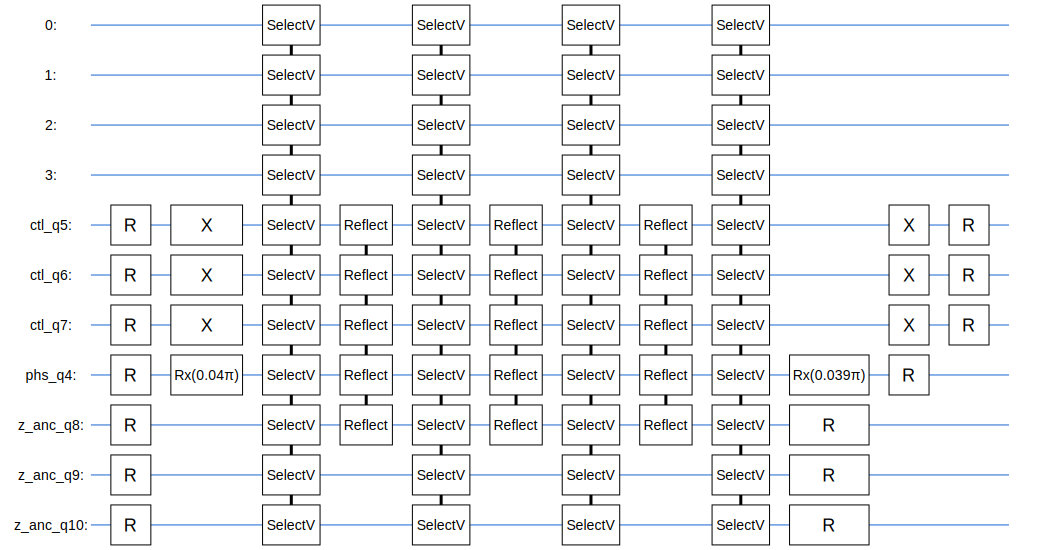

In [4]:
qsp_generator = pQSP.QSP(phis=angles, hamiltonian=qsp_H, target_size=qsp_H.problem_size)
qsp_circ      = qsp_generator.circuit()

SVGCircuit(qsp_circ)

## Convert QSP circuit to gate-level and export to OpenQasm 2.0

The next few lines show the various 'tiers' of decomposition that can be done to the QSP circuit.

This line decomposes the 'phased iterate' view of the circuit to the constituent operators (prepare, selvbase, multicz) that implement QSP

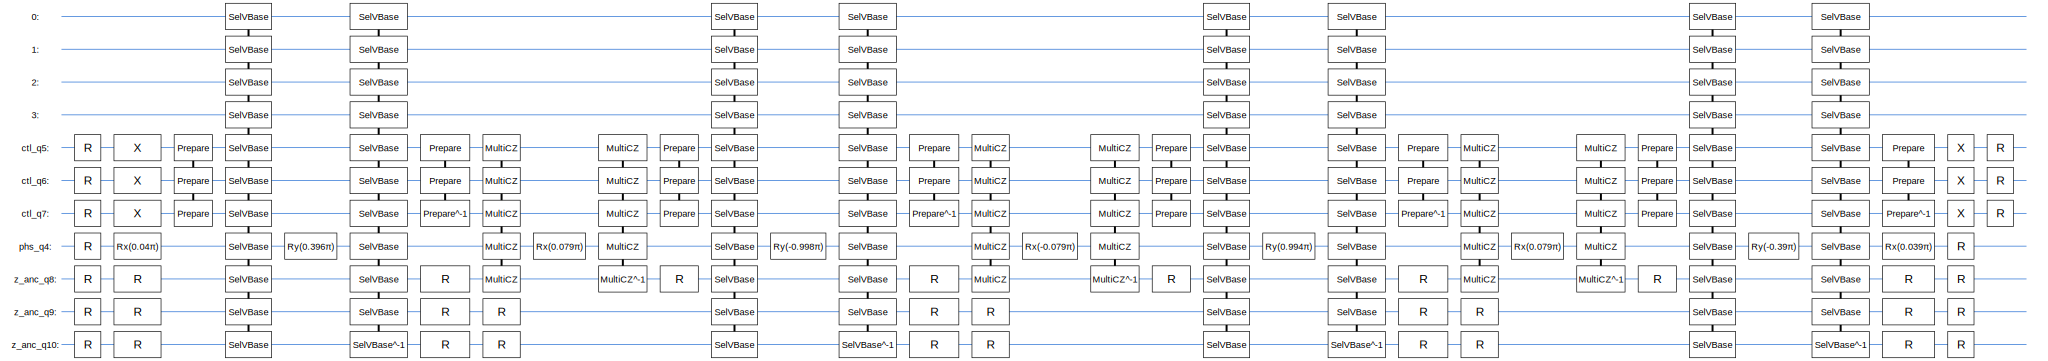

In [5]:
decomposed_once_circuit = cirq.align_left(qsp_decompose_once(qsp_circ))
decomposed_circuit      = cirq.align_left(qsp_decompose_once(decomposed_once_circuit))
cliff_plus_T_circuit    = cirq.align_left(clifford_plus_t_direct_transform(decomposed_circuit))


SVGCircuit(decomposed_once_circuit)

The following line shows just the gate-based decomposition of the circuit, into single-qubit and two-qubit gates.

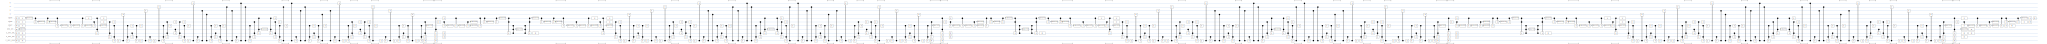

In [6]:
SVGCircuit(decomposed_circuit)

The following line shows the Clifford+T gate-based decomposition of the circuit (which transforms and approximates single qubit rotations through H/S/T gates)

In [7]:
SVGCircuit(cliff_plus_T_circuit)

Convert the Cirq circuit to OpenQASM 2.0 format, and print to stdout

In [8]:
print_to_openqasm(sys.stdout, decomposed_circuit, qubits=decomposed_circuit.all_qubits())
# print_to_openqasm(sys.stdout, cliff_plus_T_circuit)

// Generated from Cirq v1.1.0
OPENQASM 2.0;
include "qelib1.inc";
// Qubits: [z_anc_q9, q(3), z_anc_q8, q(0), z_anc_q10, ctl_q6, phs_q4, ctl_q7, q(2), ctl_q5, q(1)]
// Cirq -> OpenQASM Map : 'z_anc_q9': 'q[0]', 'q(3)': 'q[1]', 'z_anc_q8': 'q[2]', 'q(0)': 'q[3]', 'z_anc_q10': 'q[4]', 'ctl_q6': 'q[5]', 'phs_q4': 'q[6]', 'ctl_q7': 'q[7]', 'q(2)': 'q[8]', 'ctl_q5': 'q[9]', 'q(1)': 'q[10]'
qreg q[11];
reset q[9];
reset q[5];
reset q[7];
reset q[6];
reset q[2];
reset q[0];
reset q[4];
x q[9];
x q[5];
x q[7];
rx(pi*0.0401230086) q[6];
reset q[2];
reset q[0];
reset q[4];
ry(pi*0.4543710517) q[9];
cx q[9],q[5];
ry(pi*-0.054086724) q[5];
cx q[9],q[5];
ry(pi*0.445913276) q[5];
cx q[9],q[7];
ry(pi*-0.125) q[7];
cx q[5],q[7];
ry(pi*-0.125) q[7];
cx q[9],q[7];
ry(pi*-0.125) q[7];
x q[9];
cx q[5],q[7];
ccx q[6],q[9],q[2];
ry(pi*0.375) q[7];
x q[5];
x q[9];
ccx q[2],q[5],q[0];
x q[5];
ccx q[0],q[7],q[4];
z q[4];
cx q[4],q[1];
ccx q[0],q[7],q[4];
cx q[2],q[0];
x q[7];
ccx q[0],q[7],q[4];
x q[7];
z q[4]

Convert the Cirq circuit to OpenQASM 2.0 format, and print to a file

In [9]:
#Write it.
with open('my_example_qasm.qasm','w') as f:
    print_to_openqasm(f, decomposed_circuit)

#Read it.
with open('my_example_qasm.qasm','r') as f:
    lines = "".join(f.readlines())
    print(lines)

#Delete it.
os.remove('my_example_qasm.qasm')

// Generated from Cirq v1.1.0
OPENQASM 2.0;
include "qelib1.inc";
// Qubits: [q(0), q(1), q(2), q(3), ctl_q5, ctl_q6, ctl_q7, phs_q4, z_anc_q8, z_anc_q9, z_anc_q10]
// Cirq -> OpenQASM Map : 'q(0)': 'q[0]', 'q(1)': 'q[1]', 'q(2)': 'q[2]', 'q(3)': 'q[3]', 'ctl_q5': 'q[4]', 'ctl_q6': 'q[5]', 'ctl_q7': 'q[6]', 'phs_q4': 'q[7]', 'z_anc_q8': 'q[8]', 'z_anc_q9': 'q[9]', 'z_anc_q10': 'q[10]'
qreg q[11];
reset q[4];
reset q[5];
reset q[6];
reset q[7];
reset q[8];
reset q[9];
reset q[10];
x q[4];
x q[5];
x q[6];
rx(pi*0.0401230086) q[7];
reset q[8];
reset q[9];
reset q[10];
ry(pi*0.4543710517) q[4];
cx q[4],q[5];
ry(pi*-0.054086724) q[5];
cx q[4],q[5];
ry(pi*0.445913276) q[5];
cx q[4],q[6];
ry(pi*-0.125) q[6];
cx q[5],q[6];
ry(pi*-0.125) q[6];
cx q[4],q[6];
ry(pi*-0.125) q[6];
x q[4];
cx q[5],q[6];
ccx q[7],q[4],q[8];
ry(pi*0.375) q[6];
x q[5];
x q[4];
ccx q[8],q[5],q[9];
x q[5];
ccx q[9],q[6],q[10];
z q[10];
cx q[10],q[3];
ccx q[9],q[6],q[10];
cx q[8],q[9];
x q[6];
ccx q[9],q[6],q[10];
x q[6];

Pretty print the qasm circuit to include comments where Phased Iterates, Select V, and Reflect operations start and end.

In [10]:
### Pretty Print the circuit to qasm:
prettyprint_qsp_to_qasm(sys.stdout, qsp_circ)

// Generated from Cirq v1.1.0
OPENQASM 2.0;
include "qelib1.inc";
// Qubits: [z_anc_q9, q(3), z_anc_q8, q(0), z_anc_q10, ctl_q6, phs_q4, ctl_q7, q(2), ctl_q5, q(1)]
// Cirq -> OpenQASM Map : 'z_anc_q9': 'q[0]', 'q(3)': 'q[1]', 'z_anc_q8': 'q[2]', 'q(0)': 'q[3]', 'z_anc_q10': 'q[4]', 'ctl_q6': 'q[5]', 'phs_q4': 'q[6]', 'ctl_q7': 'q[7]', 'q(2)': 'q[8]', 'ctl_q5': 'q[9]', 'q(1)': 'q[10]'
qreg q[11];
reset q[9];
reset q[5];
reset q[7];
reset q[6];
reset q[2];
reset q[0];
reset q[4];
x q[9];
x q[5];
x q[7];
rx(pi*0.0401230086) q[6];
// START PHASED_ITERATE_0
// START SELECT_V
ry(pi*0.4543710517) q[9];
cx q[9],q[5];
ry(pi*-0.054086724) q[5];
cx q[9],q[5];
ry(pi*0.445913276) q[5];
cx q[9],q[7];
ry(pi*-0.125) q[7];
cx q[5],q[7];
ry(pi*-0.125) q[7];
cx q[9],q[7];
ry(pi*-0.125) q[7];
cx q[5],q[7];
ry(pi*0.375) q[7];
reset q[2];
reset q[0];
reset q[4];
x q[9];
x q[5];
ccx q[6],q[9],q[2];
x q[9];
ccx q[2],q[5],q[0];
x q[5];
ccx q[0],q[7],q[4];
z q[4];
cx q[4],q[1];
ccx q[0],q[7],q[4];
cx q[2],q[0]